# Preprocessing

## Objetivos del Cuaderno

1. **Generación de Features Agregadas**: Crear nuevas características a partir de los datos originales para representar patrones de consumo de manera más significativa y reducir la dimensionalidad.
2. **Manejo de Valores Faltantes** (KNNImputer o SoftImpute)
3. **Escalado de Características** (`StandardScaler`)

## Introducción

El dataset contiene información horaria del consumo energético de aproximadamente 130 viviendas durante un período de dos años. Cada registro incluye:
- **CUPS**: Identificador único de la vivienda.
- **Fecha**: Día específico del registro.
- **Hora**: Hora del día (1 a 24).
- **Consumo_kWh**: Consumo energético en kilovatios-hora.

Dado el volumen de datos, es necesario crear características agregadas que representen patrones de consumo a nivel diario, semanal, mensual, etc., para facilitar el análisis y el clustering.


## Preprocesamiento y Generación de Features

Antes de aplicar el clustering, comenzaremos con:
1. Preprocesamiento y Generación de Features
    - Justificación del Pipeline:
    El preprocesamiento sistemático es crítico porque:
        - **Consistencia**: Las estaciones tienen patrones de consumo fundamentalmente distintos.
        - **Robustez**: Las métricas propuestas (percentiles, FFT) capturan tanto comportamientos típicos como anomalías.
        - **Interpretabilidad**: La separación por contextos naturales (estaciones) facilita la acción sobre resultados.
2. **Creación de Features Agregadas**:
    **Subanálisis (por vivienda):**
    - Primavera
    - Verano
    - Otoño
    - Invierno
    - Análisis general

    **Métricas a calcular para cada parte:**
    | Variable                        | Descripción                                      |
    |---------------------------------|--------------------------------------------------|
    | Media y Desviación Estándar     | Tendencia central y dispersión                  |
    | Asimetría (Skewness)            | Simetría de la distribución                     |
    | Curtosis                        | Picudez/plenitud de la distribución             |
    | Energía (FFT)                   | Potencia acumulada de la señal                  |
    | Frecuencia dominante (FFT)      | Periodicidad más fuerte                         |
    | Mediana y percentiles (25, 75)  | Distribución robusta                            |

3. **Normalización de Datos**: Escalar las características para que todas tengan el mismo rango y no dominen el análisis.

Una vez que los datos estén preprocesados y las nuevas características estén listas, procederemos con la aplicación de K-Means y la evaluación de los resultados.

Imports

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from fancyimpute import SoftImpute
from sklearn.metrics import silhouette_score, mean_absolute_error, davies_bouldin_score
import warnings

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("../data/vertical_preprocessed_data_2.csv", sep=";")

Funciones

In [79]:
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    elif mes in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'


def calcular_features(consumos):
    consumos = np.array(consumos)
    if len(consumos) < 2:
        return dict.fromkeys([
            'media', 'std', 'skewness', 'kurtosis',
            'energia_fft', 'frecuencia_dominante',
            'mediana', 'p25', 'p75'
        ], np.nan)

    media = np.mean(consumos)
    std = np.std(consumos)
    skewness = skew(consumos)
    kurt = kurtosis(consumos)

    fft_vals = fft(consumos)
    fft_powers = np.abs(fft_vals)**2
    energia = np.sum(fft_powers) / len(fft_powers)
    frec_dom = np.argmax(fft_powers[1:]) + 1 if len(fft_powers) > 1 else np.nan

    return {
        'media': media,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurt,
        'energia_fft': energia,
        'frecuencia_dominante': frec_dom,
        'mediana': np.median(consumos),
        'p25': np.percentile(consumos, 25),
        'p75': np.percentile(consumos, 75)
    }

In [80]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['hora'].astype(int)
df['dia_semana'] = df['fecha'].dt.dayofweek
df['es_fin_de_semana'] = df['dia_semana'] >= 5
df['mes'] = df['fecha'].dt.month

df['estacion'] = df['mes'].apply(obtener_estacion)

df_grouped = df.groupby(['cups', 'fecha', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# Diccionario donde las claves serán cups y los valores serán diccionarios de features
features_por_cups = {}

# 1. Subanálisis por estación (sin dividir por tipo de día)
for (cups, estacion), grupo in df_grouped.groupby(['cups', 'estacion']):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    prefix = f"{estacion}"

    if cups not in features_por_cups:
        features_por_cups[cups] = {}

    for key, val in feats.items():
        features_por_cups[cups][f"{key}_{prefix}"] = val

# 2. Subanálisis ANUAL completo (sin dividir) - Se mantiene igual
for cups, grupo in df_grouped.groupby('cups'):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    for key, val in feats.items():
        features_por_cups[cups][f"{key}_anual"] = val

df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
df_features_final.reset_index(inplace=True)
df_features_final.rename(columns={'index': 'cups'}, inplace=True)
df_features_final.set_index('cups', inplace=True)

In [81]:
# df['fecha'] = pd.to_datetime(df['fecha'])
# df['hora'] = df['hora'].astype(int)
# df['dia_semana'] = df['fecha'].dt.dayofweek
# df['es_fin_de_semana'] = df['dia_semana'] >= 5
# df['mes'] = df['fecha'].dt.month

# df['estacion'] = df['mes'].apply(obtener_estacion)

# df_grouped = df.groupby(['cups', 'fecha', 'es_fin_de_semana', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# # Diccionario donde las claves serán cups y los valores serán diccionarios de features
# features_por_cups = {}

# # 1. Subanálisis por estación y tipo de día (laboral/finde)
# for (cups, estacion, es_finde), grupo in df_grouped.groupby(['cups', 'estacion', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"{estacion}_{tipo_dia}"
    
#     if cups not in features_por_cups:
#         features_por_cups[cups] = {}
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 2. Subanálisis ANUAL dividido en laboral/finde
# for (cups, es_finde), grupo in df_grouped.groupby(['cups', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"anual_{tipo_dia}"  # Cambiado a "anual_laboral" y "anual_finde"
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 3. Subanálisis ANUAL completo (sin dividir)
# for cups, grupo in df_grouped.groupby('cups'):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_anual"] = val  # Se mantiene igual

# df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
# df_features_final.reset_index(inplace=True)
# df_features_final.rename(columns={'index': 'cups'}, inplace=True)
# df_features_final.set_index('cups', inplace=True)

### Matriz de Correlación

Matriz de Correlación:
                                 media_invierno  std_invierno  \
media_invierno                        1.000000      0.840128   
std_invierno                          0.840128      1.000000   
skewness_invierno                    -0.645887     -0.544706   
kurtosis_invierno                    -0.493550     -0.480077   
energia_fft_invierno                  0.839330      0.874305   
frecuencia_dominante_invierno        -0.104640     -0.068603   
mediana_invierno                      0.866193      0.482343   
p25_invierno                          0.693958      0.280306   
p75_invierno                          0.948512      0.725276   
media_otoño                           0.880786      0.669790   
std_otoño                             0.877199      0.918304   
skewness_otoño                       -0.465249     -0.237981   
kurtosis_otoño                       -0.461140     -0.335243   
energia_fft_otoño                     0.861430      0.830564   
frecuencia_domin

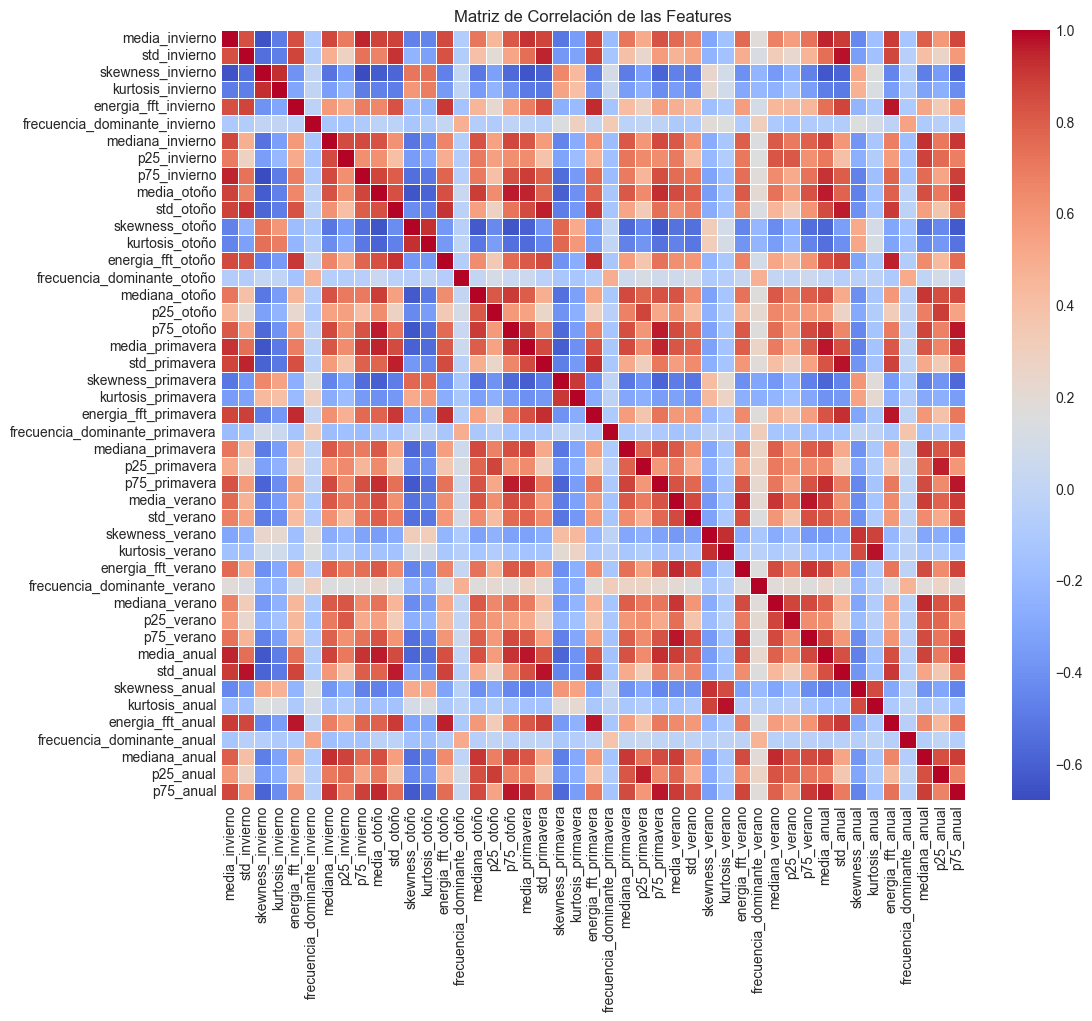


Pares de variables altamente correlacionadas (abs(corr) > 0.8):
 [('std_invierno', 'media_invierno'), ('kurtosis_invierno', 'skewness_invierno'), ('energia_fft_invierno', 'media_invierno'), ('energia_fft_invierno', 'std_invierno'), ('mediana_invierno', 'media_invierno'), ('p25_invierno', 'mediana_invierno'), ('p75_invierno', 'media_invierno'), ('p75_invierno', 'mediana_invierno'), ('media_otoño', 'media_invierno'), ('media_otoño', 'mediana_invierno'), ('media_otoño', 'p75_invierno'), ('std_otoño', 'media_invierno'), ('std_otoño', 'std_invierno'), ('std_otoño', 'energia_fft_invierno'), ('std_otoño', 'p75_invierno'), ('std_otoño', 'media_otoño'), ('kurtosis_otoño', 'skewness_otoño'), ('energia_fft_otoño', 'media_invierno'), ('energia_fft_otoño', 'std_invierno'), ('energia_fft_otoño', 'energia_fft_invierno'), ('energia_fft_otoño', 'media_otoño'), ('energia_fft_otoño', 'std_otoño'), ('mediana_otoño', 'mediana_invierno'), ('mediana_otoño', 'media_otoño'), ('p25_otoño', 'mediana_otoño'), ('

In [82]:
correlation_matrix = df_features_final.corr()

print("Matriz de Correlación:\n", correlation_matrix)

#Heatmap de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de las Features')
plt.show()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if abs(upper_triangle.loc[row, column]) > 0.8]

print("\nPares de variables altamente correlacionadas (abs(corr) > 0.8):\n", highly_correlated_pairs)

### Correcion de errores y NaN

In [83]:
df_drop = df_features_final.copy()
# Voy a eliminar dos filas (cups) que tienen NaN durante todo el invierno
cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_drop.drop(index=cups_con_nan_invierno, inplace=True, errors='ignore')

# Voy a eliminar tres filas (cups) que tienen NaN durante todo el otoño
cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_drop.drop(index=cups_con_nan_otoño, inplace=True, errors='ignore')

**Técnicas Implementadas**

### 1. KNNImputer

* **Concepto:** Imputación basada en los $k$-vecinos más cercanos ($k=5$).
* **Ventajas:**
    * Mantiene relaciones no lineales entre variables.
    * Considera la similitud entre registros completos.

### 2. SoftImpute

* **Concepto:** Imputación basada en factorización matricial (descomposición SVD).
* **Ventajas:**
    * Eficiente para matrices grandes y dispersas.
    * Maneja bien patrones de datos faltantes aleatorios.


In [84]:
# Opción 1: KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(
    knn_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_knn.to_csv("dataset/features_KNNImputer.csv")

# Opción 2: SoftImpute
soft_imputer = SoftImpute()
df_soft = pd.DataFrame(
    soft_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_soft.to_csv("dataset/features_SoftImpute.csv")

# Opción 3: Dataset original (sin imputar) para comparación
df_drop.to_csv("dataset/features_drop.csv")

[SoftImpute] Max Singular Value of X_init = 115082.524340
[SoftImpute] Iter 1: observed MAE=23.523659 rank=6
[SoftImpute] Iter 2: observed MAE=23.523622 rank=6
[SoftImpute] Iter 3: observed MAE=23.523051 rank=6
[SoftImpute] Iter 4: observed MAE=23.524372 rank=6
[SoftImpute] Iter 5: observed MAE=23.525516 rank=6
[SoftImpute] Iter 6: observed MAE=23.525970 rank=6
[SoftImpute] Iter 7: observed MAE=23.526142 rank=6
[SoftImpute] Iter 8: observed MAE=23.526207 rank=6
[SoftImpute] Stopped after iteration 8 for lambda=2301.650487


In [85]:
tiene_nans = df_knn.isnull().any().any()

if tiene_nans:

    columnas_con_nans = df_features_final.columns[df_features_final.isnull().any()].tolist()
    print(f"Las columnas con valores NaN son: {columnas_con_nans}")

    nans_por_columna = df_features_final.isnull().sum()
    print("\nNúmero de NaNs por columna:")
    print(nans_por_columna[nans_por_columna > 0])

else:
    print("El dataset no contiene ningún valor NaN.")

El dataset no contiene ningún valor NaN.


### Aqui eligimos con que dataset hacemos las cosas (por ahora KNNIMPUTER)

In [86]:
df = pd.read_csv("dataset/features_KNNImputer.csv", index_col='cups')

In [87]:
num_columnas = df.shape[1]
print(f"El DataFrame df_features_final tiene {num_columnas} columnas.")
nombres_columnas = df.columns.tolist()
print(f"Los nombres de las columnas son: {nombres_columnas}")

El DataFrame df_features_final tiene 45 columnas.
Los nombres de las columnas son: ['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno', 'media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño', 'media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera', 'media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano', 'media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominante_anual', 'mediana_anual', 'p25_anual', 'p75_anual']


In [88]:
columnas_invierno = [col for col in nombres_columnas if re.search(r'_invierno', col)]
columnas_primavera = [col for col in nombres_columnas if re.search(r'_primavera', col)]
columnas_verano = [col for col in nombres_columnas if re.search(r'_verano', col)]
columnas_otoño = [col for col in nombres_columnas if re.search(r'_otoño', col)]
columnas_anuales = [col for col in nombres_columnas if re.search(r'_anual', col)]

print("\nColumnas relacionadas con Invierno:")
print(len(columnas_invierno))
print(columnas_invierno)
print("\nColumnas relacionadas con Primavera:")
print(len(columnas_primavera))
print(columnas_primavera)
print("\nColumnas relacionadas con Verano:")
print(len(columnas_verano))
print(columnas_verano)
print("\nColumnas relacionadas con Otoño:")
print(len(columnas_otoño))
print(columnas_otoño)
print("\nColumnas con agregación Anual:")
print(len(columnas_anuales))
print(columnas_anuales)


Columnas relacionadas con Invierno:
9
['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno']

Columnas relacionadas con Primavera:
9
['media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera']

Columnas relacionadas con Verano:
9
['media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano']

Columnas relacionadas con Otoño:
9
['media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño']

Columnas con agregación Anual:
9
['media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominant

Falta poir quitar las ultimas dos cups que no tienen datos de invierno por ahora
luego normalizar los datos
luego aplicar kmeans y por metedos de sacar k

### StandardScaler

StandardScaler, es una técnica fundamental de preprocesamiento de datos utilizada en machine learning, especialmente antes de aplicar algoritmos sensibles a la escala de las características (features). Su objetivo principal es transformar las características de manera que tengan una media de 0 y una desviación estándar de 1.

**La Fórmula Matemática:**

Para cada valor \(x_i\) de una característica dada, StandardScaler aplica la siguiente fórmula:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

Donde:

* \(z_i\) es el valor escalado (el z-score) del dato \(x_i\).
* \(x_i\) es el valor original del dato.
* \(\mu\) (mu) es la media de todos los valores de esa característica en el conjunto de entrenamiento.
* \(\sigma\) (sigma) es la desviación estándar de todos los valores de esa característica en el conjunto de entrenamiento.

In [89]:
features = df.values

scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

df_scaled_features = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

df_scaled_features.to_csv("dataset/features_StandardScaler.csv")

In [90]:
df = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')